In [19]:
# import required libraries
import torch
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import cv2 as cv
import time
import numpy as np 
import torchvision.models as models
from PIL import Image
import torch.nn as nn
import json

In [20]:
def setDevice():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using {device}")
    return device

In [21]:
def loadYoloModel():
    model = torch.hub.load("ultralytics/yolov5", "yolov5s", pretrained=True)
    return model

In [22]:
def detectSingleImage(imagePath, device, model):
    start = time.time()

    image = Image.open(imagePath).convert('RGB')
    with torch.no_grad():
        result = model(image)
        result.print()
        #print(result.xyxy)
        #print("Names")
        #print(result.pandas().xyxy[0]["name"])
        resultNames = result.pandas().xyxy[0]["name"]
        predictions = result.xyxy[0]

        for i in range(len(predictions)):
            prediction = predictions[i].tolist()
            # print(prediction)
            #print(f"prediction {i}, {resultNames[i]}")
            #print(prediction)
            
            
            if resultNames[i] == "person":
                indexOfClosest = None
                distance = image.size[0]
                for j in range(len(predictions)):
                    prediction2 = predictions[j].tolist()

                    if resultNames[j] == "person":
                        continue
                    else:
                        #print("prediction for non human object")
                        #print(prediction2)

                        # pil image pixel value changing
                        temp = np.array(image)

                        # debug (draw one pixel green)
                        #print("coordinates")
                        #print(round(prediction2[0]))
                        #print(round(prediction2[1]))
                        temp[round(prediction2[1])][round(prediction2[0])]   = [0, 255, 0]
                        image = Image.fromarray(temp)
                        # debug

                        personCenters = (
                            (prediction[2] + prediction[0]) // 2, # (xmax + xmin) / 2  -> x but column value
                            (prediction[3] + prediction[1]) // 2  # (ymax + ymin) / 2  -> y but row value
                        )

                        objCenters = (
                            (prediction2[2] + prediction2[0]) // 2, # (xmax + xmin) / 2  -> x but column value
                            (prediction2[3] + prediction2[1]) // 2  # (ymax + ymin) / 2  -> y but row value
                        )
                        ImageDraw.Draw(image).line((personCenters[0],personCenters[1], objCenters[0], objCenters[1] ), fill="red", width=3)

                        radius = 4
                        ImageDraw.Draw(image).ellipse((personCenters[0]-radius,personCenters[1]-radius,personCenters[0]+radius, personCenters[1]+radius), fill="red", outline="red")
                        ImageDraw.Draw(image).ellipse((objCenters[0]-radius,objCenters[1]-radius,objCenters[0]+radius, objCenters[1]+radius), fill="red", outline="red")


            x_min = round(prediction[0])
            y_min = round(prediction[1])
            x_max = round(prediction[2])
            y_max = round(prediction[3])
            cfdnc = prediction[4]
            if cfdnc < 0.4 and resultNames[i] != "person":
                continue
            color = None
            if resultNames[i] == "person":
                color = "blue"
            else:
                color = "green"  
            ImageDraw.Draw(image).rectangle([x_min,y_min,x_max,y_max], outline =color, width=3)
    
    print(f"Took {time.time()-start} seconds.")
    return image

In [23]:
# set device
device = setDevice()

Using cpu


In [24]:
# loading pretrained model
yoloModel = loadYoloModel()
yoloModel

Using cache found in C:\Users\Burak/.cache\torch\hub\ultralytics_yolov5_master


requirements: seaborn>=0.11.0 not found and is required by YOLOv5, attempting auto-update...


Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


requirements: Command 'pip install 'seaborn>=0.11.0'' returned non-zero exit status 1.
requirements: 1 package updated per C:\Users\Burak\.cache\torch\hub\ultralytics_yolov5_master\requirements.txt
requirements:  Restart runtime or rerun command for updates to take effect



YOLOv5  2021-6-7 torch 1.8.1+cpu CPU



AutoShape(
  (model): Model(
    (model): Sequential(
      (0): Focus(
        (conv): Conv(
          (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
    

image 1/1: 640x457 1 person, 1 bicycle, 3 cars, 1 truck
Speed: 4.0ms pre-process, 237.9ms inference, 1.0ms NMS per image at shape (1, 3, 640, 480)
Took 0.26978468894958496 seconds.


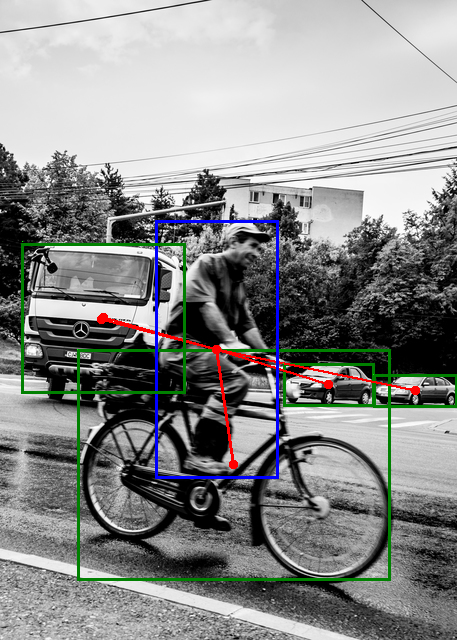

In [25]:
resultImage = detectSingleImage("./dataset/train2015/HICO_train2015_00000015.jpg", device, yoloModel)
resultImage

In [123]:
def readAnnotationFiles():
    trainJSONFile = open('./annotations/train_data_with_obj_id.json')
    testJSONFile = open("./annotations/test_data_with_obj_id.json")
    verbJSONFile = open('./annotations/verb_dict.json')
    verbFile = open('./annotations/hico_list_vb.txt',"r")
    hoiFile = open('./annotations/hico_list_hoi.txt', "r")   
    objFile = open('./annotations/hico_list_obj.txt', "r")

    # reading and configuring txt files
    verbFileArray = verbFile.read().split("\n")
    hoiFileArray = hoiFile.read().split("\n")
    objFileArray = objFile.read().split("\n")
    
    for i in range(len(objFileArray)):
        objFileArray[i] = objFileArray[i].strip(" ").split(" ")[-1]
    
    # loading json files
    trainAnnotationDictionary = json.load(trainJSONFile)
    verbDictionary = json.load(verbJSONFile)
    testAnnotationDictionary = json.load(testJSONFile)

    # closing files which has opened
    trainJSONFile.close()
    verbJSONFile.close()
    verbFile.close()
    hoiFile.close()
    objFile.close()
    testJSONFile.close()
    
    return trainAnnotationDictionary, testAnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray, objFileArray


def targetVectorOfAllImages(AnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray):
    imageNames = AnnotationDictionary["name"]
    actionNumbers = AnnotationDictionary["action_no"]
    objectList = AnnotationDictionary["obj_list"]
    objectIDs = AnnotationDictionary["obj_id"]
    
    verbArray = list(verbDictionary.values())

    targetVectors = []
    for i in imageNames:
        actionIndexes = actionNumbers[i]
        targetVector = np.zeros(117)

        for j in actionIndexes:
            # getting relevant verb
            tempVerb = hoiFileArray[j - 1].strip(" ").split(" ")[-1]

            # getting index of verb
            tempIndex = verbArray.index(tempVerb)

            # setting correct values
            targetVector[tempIndex] = 1

            print([imageNames[i]], objectList[i], [tempVerb])
        
        targetVectors.append(targetVector)
        
    return targetVectors
 

def getIndividualTargetVector(imageName, AnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray, objFileArray):
    imageNames = AnnotationDictionary["name"]
    actionNumbers = AnnotationDictionary["action_no"]
    objectList = AnnotationDictionary["obj_list"]
    objectIDs = AnnotationDictionary["obj_id"]
    
    verbArray = list(verbDictionary.values())
    imageNameArray = list(imageNames.values())
    
    
    # extract image index
    imageIndex = imageNameArray.index(imageName)
    
    
    # only image names
    imageNamesList = list(imageNames.values())
    
    #initial target vector
    targetVector = np.zeros(117)
    
    # extract action indexes 
    actionIndexes = list(actionNumbers.values())[imageIndex]
    
    
    # convert object list 
    objectList = list(objectList.values())
    for i in actionIndexes:
        verb = hoiFileArray[i - 1].strip(" ").split(" ")[-1]
        
        tempIndex = verbArray.index(verb)
        
        targetVector[tempIndex] = 1
        
        #obj = objectList[imageIndex - 1].split(" ")[-1]
        objIndex = objFileArray.index(objectList[imageIndex - 1][0])
        
        #print([imageNamesList[imageIndex - 1]], objectList[imageIndex - 1], [verb])
        #print(imageIndex - 1)
        #print(objIndex)
    
    return [objIndex, targetVector]   



In [124]:
"""read needed files and configure"""
trainAnnotationDictionary, testAnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray, objFileArray = readAnnotationFiles()

"""create target vector for all the images"""
# targetVectorOfAllImages(trainAnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray

"""return target vector of given image"""

targetVector = getIndividualTargetVector("HICO_train2015_00000016.jpg",trainAnnotationDictionary,verbDictionary, verbFileArray, hoiFileArray, objFileArray)
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary


print(targetVector)  

[9, array([          0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                 0,           0,       

In [129]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display


dataset_path = './dataset/train2015'

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),

    transforms.Resize(300),
    transforms.CenterCrop(256),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])



dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)

myDataset = []


for i in range(len(dataset.imgs)):
    
    tempImageName = dataset.imgs[i][0].split("\\")[-1]
    targetVector = getIndividualTargetVector(tempImageName,trainAnnotationDictionary,verbDictionary, verbFileArray, hoiFileArray, objFileArray)
    dataset.imgs[i] = (dataset.imgs[i][0], targetVector)
    
    if (i % 1000 == 999):
        break # burayı boz
    

print("hawli")    



('./dataset/train2015\\train\\HICO_train2015_00000001.jpg', [45, array([          0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,     

('./dataset/train2015\\train\\HICO_train2015_00001260.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001261.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001262.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001263.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001264.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001265.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001266.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001267.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001268.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001269.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001270.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001271.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001272.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001273.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001274.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00001275.j

('./dataset/train2015\\train\\HICO_train2015_00003113.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003114.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003115.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003116.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003117.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003118.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003119.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003120.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003121.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003122.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003123.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003124.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003125.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003126.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003127.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00003128.j

('./dataset/train2015\\train\\HICO_train2015_00004444.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004445.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004446.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004447.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004448.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004449.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004450.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004451.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004452.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004453.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004454.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004455.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004456.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004457.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004458.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00004459.j

('./dataset/train2015\\train\\HICO_train2015_00005934.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005935.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005936.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005937.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005938.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005939.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005940.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005941.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005942.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005943.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005944.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005945.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005946.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005947.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005948.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00005949.j

('./dataset/train2015\\train\\HICO_train2015_00007450.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007451.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007452.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007453.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007454.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007455.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007456.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007457.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007458.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007459.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007460.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007461.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007462.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007463.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007464.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00007465.j

('./dataset/train2015\\train\\HICO_train2015_00008740.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008741.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008742.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008743.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008744.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008745.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008746.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008747.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008748.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008749.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008750.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008751.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008752.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008753.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008754.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00008755.j

('./dataset/train2015\\train\\HICO_train2015_00009988.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009989.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009990.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009991.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009992.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009993.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009994.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009995.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009996.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009997.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009998.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00009999.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00010000.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00010001.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00010002.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00010003.j

('./dataset/train2015\\train\\HICO_train2015_00011905.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011906.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011907.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011908.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011909.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011910.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011911.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011912.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011913.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011914.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011915.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011916.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011917.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011918.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011919.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00011920.j

('./dataset/train2015\\train\\HICO_train2015_00013065.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013066.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013067.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013068.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013069.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013070.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013071.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013072.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013073.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013074.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013075.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013076.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013077.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013078.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013079.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00013080.j

('./dataset/train2015\\train\\HICO_train2015_00014421.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014422.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014423.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014424.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014425.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014426.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014427.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014428.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014429.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014430.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014431.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014432.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014433.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014434.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014435.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00014436.j

('./dataset/train2015\\train\\HICO_train2015_00015761.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015762.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015763.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015764.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015765.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015766.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015767.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015768.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015769.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015770.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015771.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015772.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015773.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015774.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015775.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00015776.j

('./dataset/train2015\\train\\HICO_train2015_00017349.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017350.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017351.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017352.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017353.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017354.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017355.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017356.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017357.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017358.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017359.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017360.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017361.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017362.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017363.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00017364.j

('./dataset/train2015\\train\\HICO_train2015_00018870.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018871.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018872.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018873.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018874.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018875.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018876.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018877.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018878.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018879.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018880.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018881.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018882.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018883.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018884.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00018885.j

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



('./dataset/train2015\\train\\HICO_train2015_00024956.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024957.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024958.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024959.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024960.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024961.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024962.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024963.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024964.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024965.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024966.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024967.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024968.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024969.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024970.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00024971.j

('./dataset/train2015\\train\\HICO_train2015_00026723.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026724.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026725.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026726.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026727.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026728.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026729.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026730.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026731.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026732.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026733.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026734.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026735.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026736.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026737.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00026738.j

('./dataset/train2015\\train\\HICO_train2015_00028123.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028124.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028125.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028126.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028127.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028128.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028129.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028130.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028131.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028132.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028133.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028134.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028135.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028136.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028137.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00028138.j

('./dataset/train2015\\train\\HICO_train2015_00029492.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029493.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029494.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029495.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029496.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029497.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029498.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029499.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029500.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029501.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029502.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029503.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029504.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029505.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029506.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00029507.j

('./dataset/train2015\\train\\HICO_train2015_00030940.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030941.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030942.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030943.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030944.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030945.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030946.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030947.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030948.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030949.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030950.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030951.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030952.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030953.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030954.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00030955.j

('./dataset/train2015\\train\\HICO_train2015_00032501.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032502.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032503.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032504.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032505.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032506.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032507.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032508.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032509.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032510.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032511.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032512.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032513.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032514.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032515.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00032516.j

('./dataset/train2015\\train\\HICO_train2015_00034025.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034026.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034027.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034028.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034029.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034030.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034031.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034032.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034033.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034034.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034035.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034036.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034037.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034038.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034039.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00034040.j

('./dataset/train2015\\train\\HICO_train2015_00035575.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035576.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035577.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035578.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035579.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035580.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035581.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035582.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035583.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035584.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035585.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035586.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035587.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035588.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035589.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00035590.j

('./dataset/train2015\\train\\HICO_train2015_00037027.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037028.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037029.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037030.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037031.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037032.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037033.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037034.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037035.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037036.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037037.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037038.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037039.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037040.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037041.jpg', 0)
('./dataset/train2015\\train\\HICO_train2015_00037042.j